In [1]:
import numpy as np
import pandas as pd
from scipy.special import log_softmax, softmax
import matplotlib.pyplot as plt

0.4996368956329815 0.7454347848858166


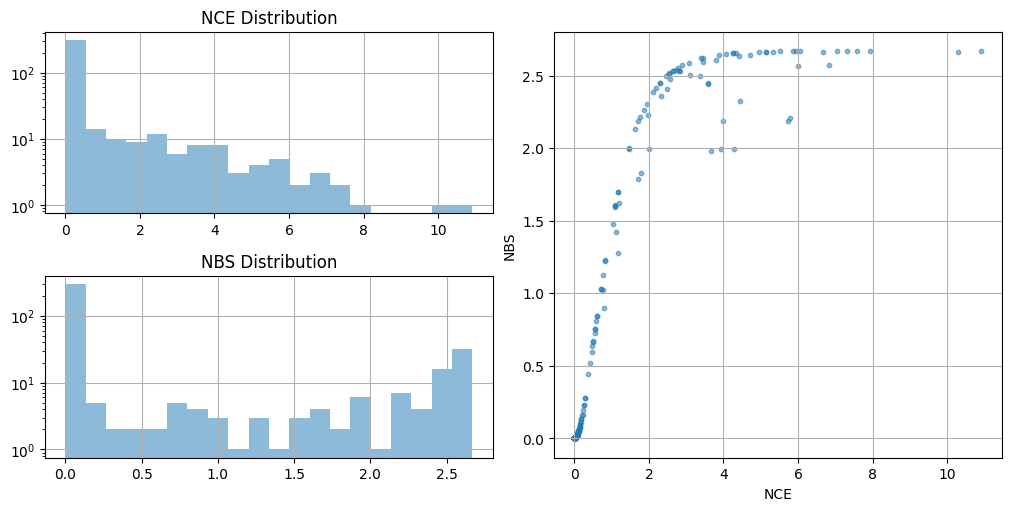

In [7]:

method2path = {
    "sft_wo_val": "../outputs/finetune_lora/{model}/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-1.0/0.7-1.0/test={dataset}/list=test_{testsamples}/",
    "sft_w_val": "../outputs/finetune_lora/{model}/{dataset}/size={size}/seed={seed}/lora_ans/0.0-0.7/0.7-1.0/test={dataset}/list=test_{testsamples}/",
    "sft_retrain": "../outputs/finetune_lora/{model}/{dataset}/size={size}/seed={seed}/lora_ans/0.0-1.0/0.7-1.0/test={dataset}/list=test_{testsamples}/",
    "sft_wo_val_plus_ts": "../outputs/lora_plus_tempscaling/{model}/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-1.0/0.7-1.0/0.7-1.0/test={dataset}/list=test_{testsamples}/",
}

dataset2testsamples = {
    "sst2": 400,
    "agnews": 400,
    "dbpedia": 700,
    "20newsgroups": 800,
    "banking77": 1000,
}

def load_data(method, dataset, size=256, model="llama3.2-1b-instruct", seed=0):
    path = method2path[method].format(
        model=model,
        dataset=dataset,
        size=size,
        seed=seed,
        testsamples=dataset2testsamples[dataset],
    )
    logprobs = log_softmax(pd.read_csv(path + "logits.csv", index_col=0, header=None).to_numpy(), axis=1)
    labels = pd.read_csv(path + "labels.csv", index_col=0, header=None).to_numpy().squeeze()
    return logprobs, labels

def compute_nce(logits, labels):
    ce_vec = -log_softmax(logits, axis=1)[np.arange(len(labels)), labels]
    priors = np.bincount(labels, minlength=logits.shape[1]) / len(labels)
    norm = -np.log(priors[labels]).mean()
    return ce_vec / norm

def compute_nbs(logits, labels):
    one_hot = np.zeros(logits.shape)
    one_hot[np.arange(len(labels)), labels] = 1
    brier = ((one_hot - softmax(logits, axis=1))**2).mean(axis=1)
    priors = np.bincount(labels, minlength=logits.shape[1]) / len(labels)
    norm = ((one_hot - priors)**2).mean()
    return brier / norm

method = "sft_wo_val"
# method = "sft_w_val"
# method = "sft_retrain"
# method = "sft_wo_val_plus_ts"

# dataset = "sst2"
# dataset = "20newsgroups"
dataset = "agnews"
# dataset = "banking77"

size = 8

fig, ax =  plt.subplot_mosaic([['upper left', 'right'],
                                ['lower left', 'right']],
                                figsize=(10, 5), layout="constrained")

for seed in range(1):
    logprobs, labels = load_data(method, dataset, size, seed=seed)
    ce = compute_nce(logprobs, labels)
    bs = compute_nbs(logprobs, labels)
    print(bs.mean(), ce.mean())
    
    ax['right'].scatter(ce, bs, alpha=0.5, s=10)
    ax['right'].set_xlabel("NCE")
    ax['right'].set_ylabel("NBS")
    ax['right'].grid(True)

    nbins = 20
    ax['upper left'].hist(ce, alpha=0.5, bins=nbins)
    ax['upper left'].set_title("NCE Distribution")
    ax['upper left'].grid(True)
    ax["upper left"].set_yscale("log")
    ax['lower left'].hist(bs, alpha=0.5, bins=nbins)
    ax['lower left'].set_title("NBS Distribution")
    ax['lower left'].grid(True)
    ax["lower left"].set_yscale("log")
plt.show()

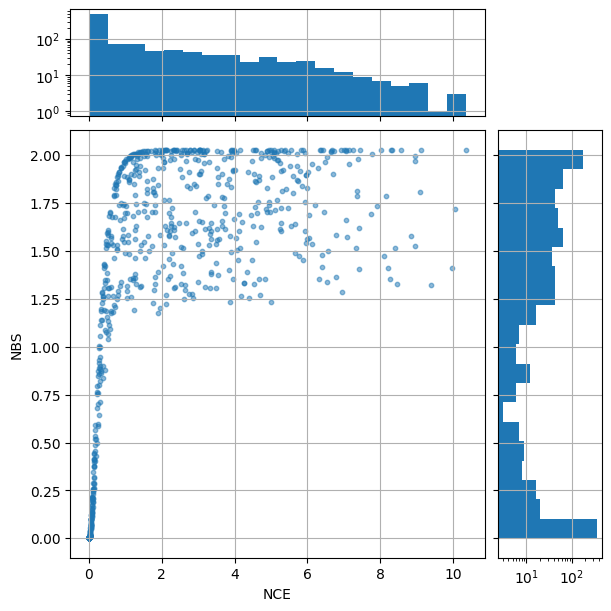

In [38]:
def scatter_hist(ce, bs, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(ce, bs, alpha=0.5, s=10)
    ax.set_xlabel("NCE")
    ax.set_ylabel("NBS")
    ax.grid(True)

    ax_histx.hist(ce, bins=nbins)
    ax_histy.hist(bs, bins=nbins, orientation='horizontal')
    ax_histx.set_yscale("log")
    ax_histy.set_xscale("log")
    ax_histx.grid(True)
    ax_histy.grid(True)

    # xinf, xsup = ax.get_xlim()
    # yinf, ysup = ax.get_ylim()
    # ax.set_xlim(min(xinf, yinf), max(xsup, ysup))
    # ax.set_ylim(min(xinf, yinf), max(xsup, ysup))
    # ax_histx.set_xlim(ax.get_xlim())
    # ax_histy.set_ylim(ax.get_ylim())

    # ax.plot([min(xinf, yinf), max(xsup, ysup)],
    #         [min(xinf, yinf), max(xsup, ysup)],
    #         ls="--", c=".3")


fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(6, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained')

logprobs, labels = load_data(method, dataset, size, seed=seed)
ce = compute_nce(logprobs, labels)
bs = compute_nbs(logprobs, labels)
scatter_hist(ce, bs, axs['scatter'], axs['histx'], axs['histy'])